This file contains the results of one experiment, which used Flair as the POS tagger and SentenceTransformer for text conversion.

In [8]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

In [9]:
df = pd.read_csv('data/clean/clean_dataset_posBERTV1.csv')
df.head()

name  \
0   Gamis Pria Dewasa Premium / Jubah Pakistan Polos   
1  Buket Bunga Mawar Flanel / Bunga wisuda / Bung...   
2  Mika Sen Depan Supra Fit New Kaca Lampu Sein D...   
3  Blazer wanita jumbo big size stik balik / plus...   
4  Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...   

                                    multiCorpus_noun  name_length  \
0                        pria premium jubah pakistan           12   
1  buket bunga mawar flanel bunga wisuda bunga so...           17   
2      mika depan fit new kaca lampu dpn motor bebek           20   
3                 blazer wanita jumbo size plus size           22   
4                  buku ilmu sosial budaya kesadaran            4   

                           multiCorpus_noun_rm10  \
0                                   pria premium   
1  buket bunga mawar bunga wisuda bunga souvenir   
2            mika fit new kaca lampu motor bebek   
3                  blazer wanita jumbo size size   
4                               buku ilmu sosial   

            multiCorpus_noun_rm20   multiCorpus_noun_rm30  \
0                    pria premium            pria premium   
1      bunga bunga bunga souvenir       bunga bunga bunga   
2  fit new kaca lampu motor bebek    new kaca lampu motor   
3   blazer wanita jumbo size size  wanita jumbo size size   
4                            buku                    buku   

    multiCorpus_noun_rm40  
0            pria premium  
1       bunga bunga bunga  
2    new kaca lampu motor  
3  wanita jumbo size size  
4                    buku

In [10]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device="cuda")

In [11]:
# list of range for each experiment
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]

# list of vectorizers for each experiment
vectorizers = {
    'original noun': np.vstack(list(model.encode(df['multiCorpus_noun'].tolist(), convert_to_numpy=True, batch_size=32))),
    'noun remove-10': np.vstack(list(model.encode(df['multiCorpus_noun_rm10'].tolist(), convert_to_numpy=True, batch_size=32))),
    'noun remove-20': np.vstack(list(model.encode(df['multiCorpus_noun_rm20'].tolist(), convert_to_numpy=True, batch_size=32))),
    'noun remove-30': np.vstack(list(model.encode(df['multiCorpus_noun_rm30'].tolist(), convert_to_numpy=True, batch_size=32))),
    'noun remove-40': np.vstack(list(model.encode(df['multiCorpus_noun_rm40'].tolist(), convert_to_numpy=True, batch_size=32)))
}

# list for storing results
results = []

In [12]:
def clustering_experiment(range_list, results):
    print(f"Evaluating range_list={range_list}...")

    for name, data in vectorizers.items():
        for cluster_range in range_list:
            silhouette_scores = []
            # K-Means clustering
            for n_clusters in cluster_range:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                labels = kmeans.fit_predict(data)
                score = silhouette_score(data, labels)
                silhouette_scores.append(score)
            
            # store results
            avg_score = sum(silhouette_scores) / len(silhouette_scores)
            best_score = max(silhouette_scores)
            results.append({
                'model_noun': name,
                'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                'avg_silhouette_score': avg_score,
                'best_silhouette_score': best_score
            })

# run experiment
clustering_experiment(range_list, results)

Evaluating range_list=[range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]...


## Analysis Experiment Results

In [13]:
# convert the results to a DataFrame for visualization
results_df = pd.DataFrame(results)

In [14]:
results_df.head()

model_noun cluster_range  avg_silhouette_score  best_silhouette_score
0   original noun          2-19              0.033268               0.055902
1   original noun       100-119              0.030748               0.032841
2   original noun       500-519              0.043077               0.043538
3   original noun     1000-1019              0.042226               0.042483
4  noun remove-10          2-19              0.045057               0.063798

### Box plot to visualize the distribution of silhouette scores by preprocessing method

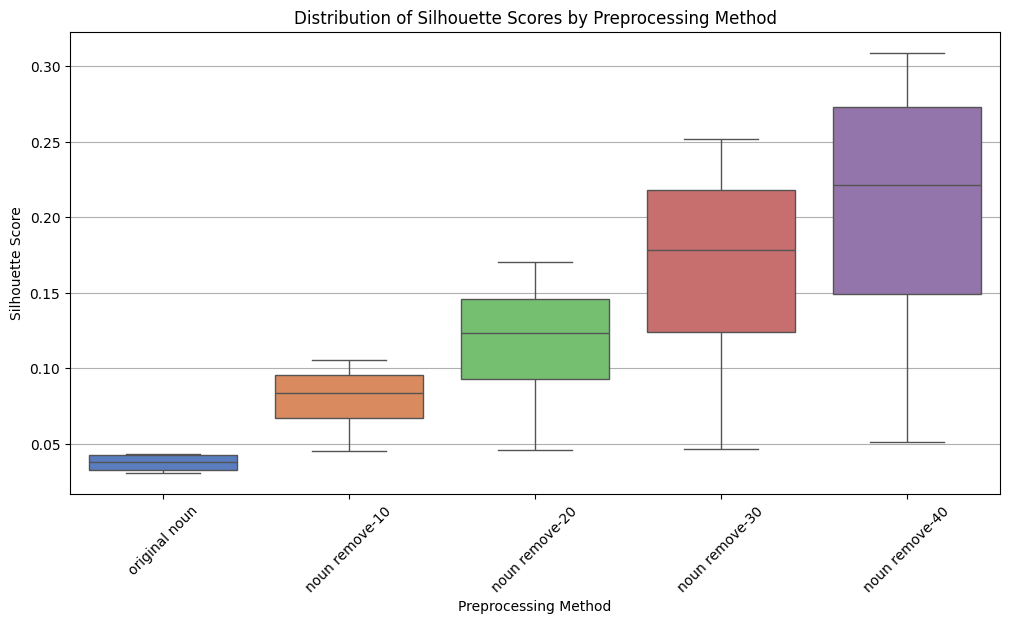

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='model_noun'
)
plt.title("Distribution of Silhouette Scores by Preprocessing Method")
plt.xlabel("Preprocessing Method")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Line plot to visualize the trend of silhouette scores over cluster range

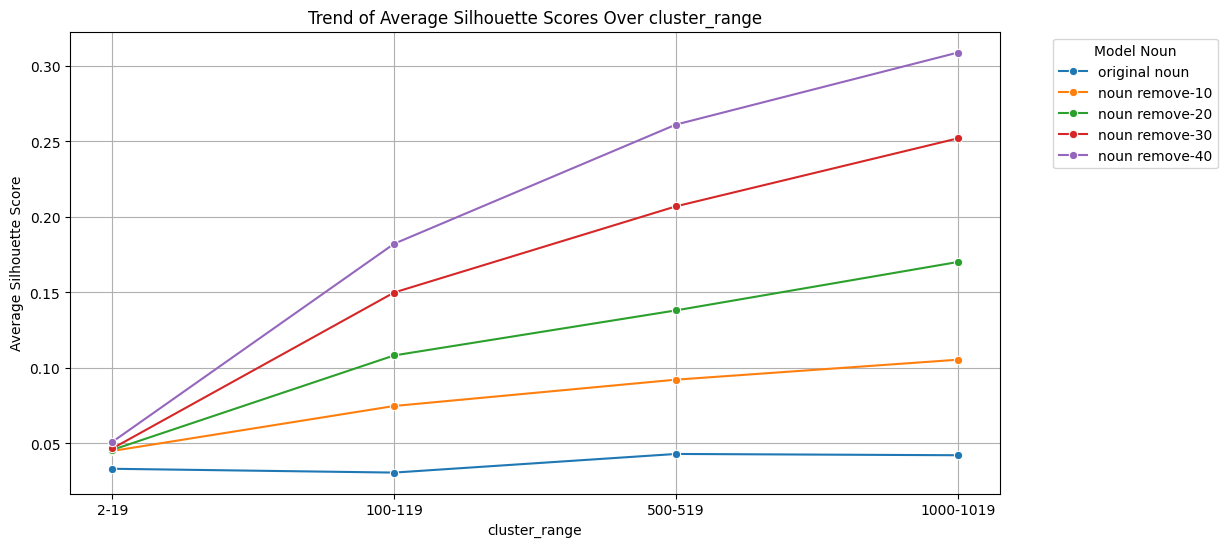

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='cluster_range',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over cluster_range")
plt.xlabel("cluster_range")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


### Facet grid plot to visualize the distribution of best silhoutte scores over cluster range for each preprocessing method

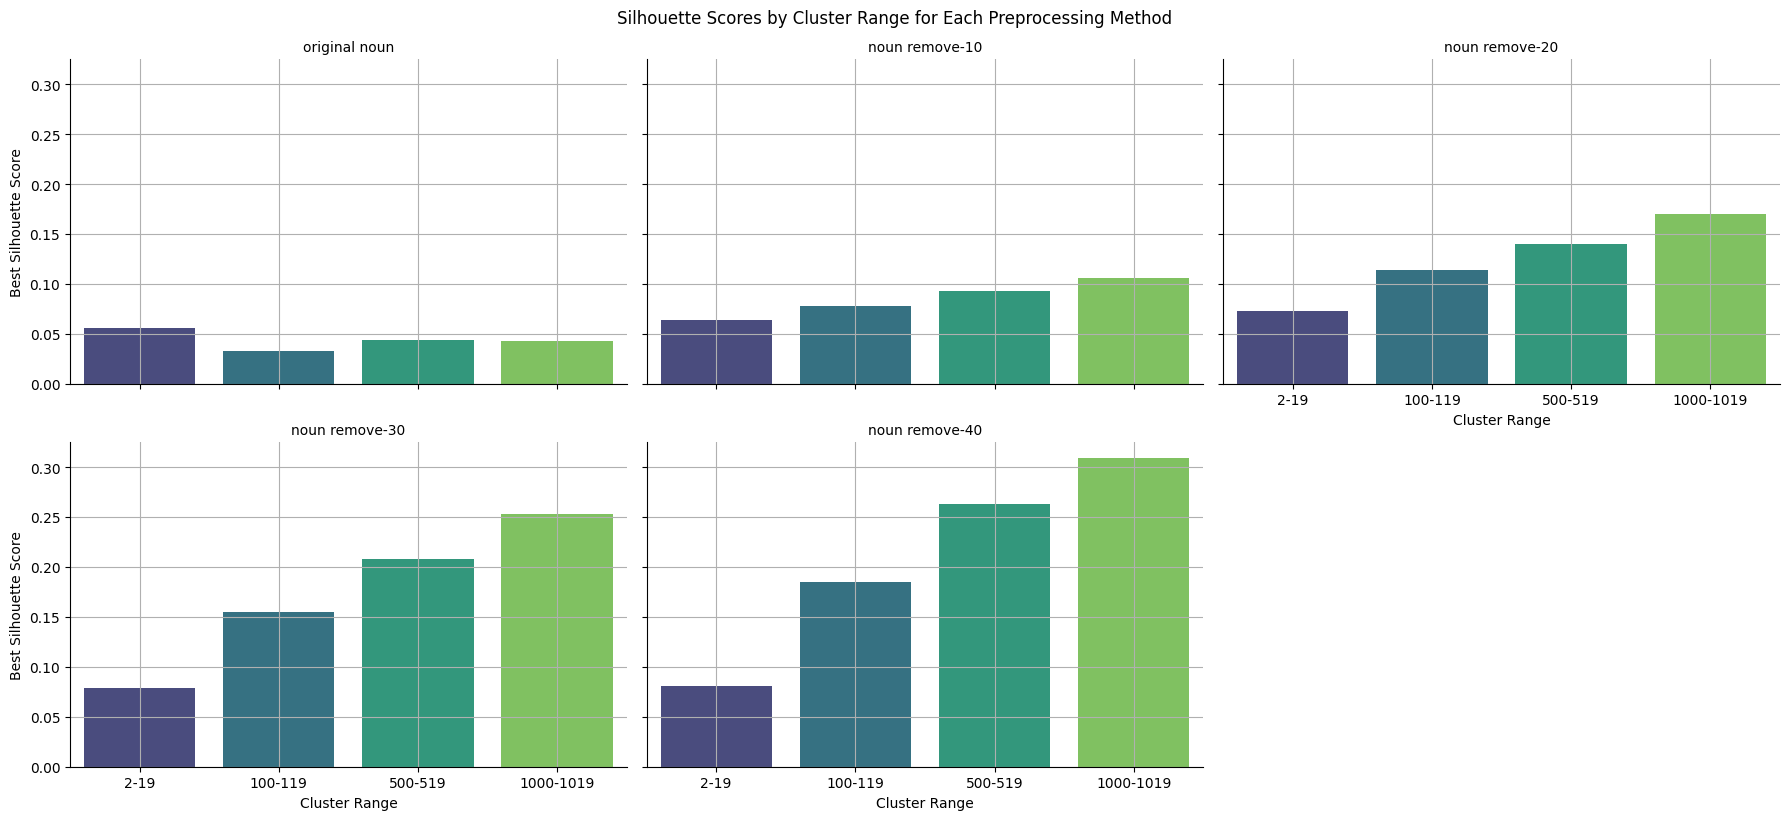

In [17]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="best_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Best Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each Preprocessing Method", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

### Facet grid plot to visualize the distribution of average silhoutte scores over cluster range for each preprocessing method

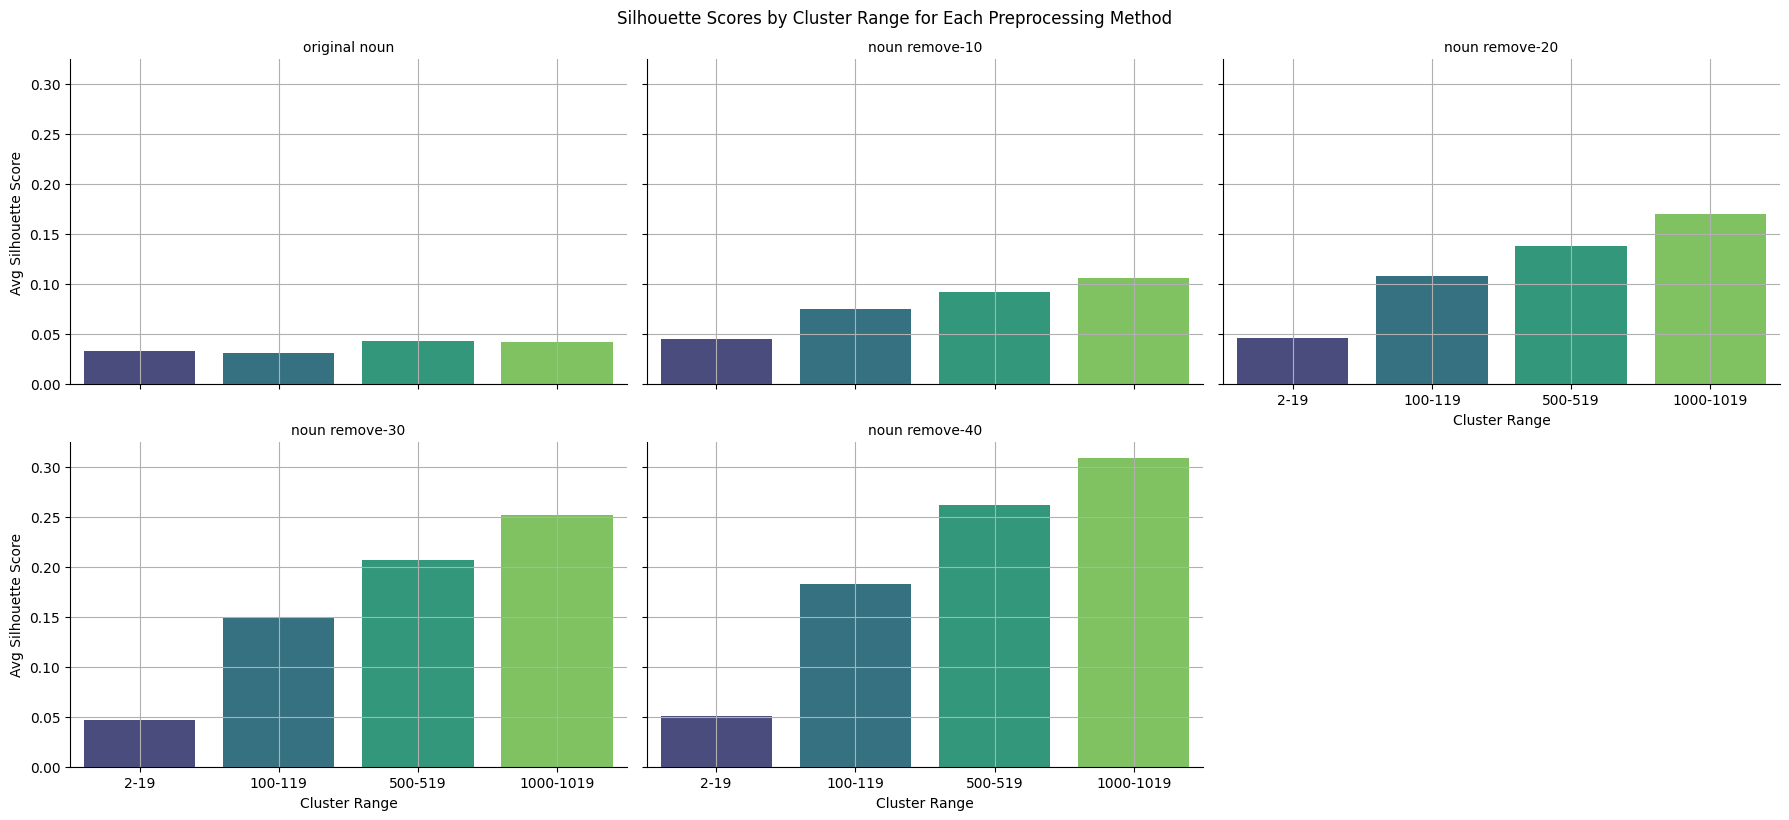

In [18]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="cluster_range")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each Preprocessing Method", y=1.02)
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()

# Choose the Best Preprocessing Method and Continue Analysis by Clustering

In [19]:
def show_cluster(column_name, cluster_number):
    pd.set_option('display.max_colwidth', None)

    # Show some product examples from each cluster
    for n_clusters in range(cluster_number):
        print(f"\nExamples of products in Cluster {n_clusters}:")
        print(df[df[column_name] == n_clusters][['name']].head(5))

    # Reset display option
    pd.reset_option('display.max_colwidth')

In [20]:
from wordcloud import WordCloud

def show_wordclouds(column_name, cluster_number):
    for n_clusters in range(cluster_number):
        # get the data in the cluster
        cluster_data = df[df[column_name] == n_clusters]['name'].dropna().tolist()
        text = " ".join(cluster_data)  # join all the text in the cluster

        # Generate WordCloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Show WordCloud
        plt.figure(figsize=(6, 3))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {n_clusters}", fontsize=16)
        plt.show()

## Find Optimum K Cluster using Elbow Method

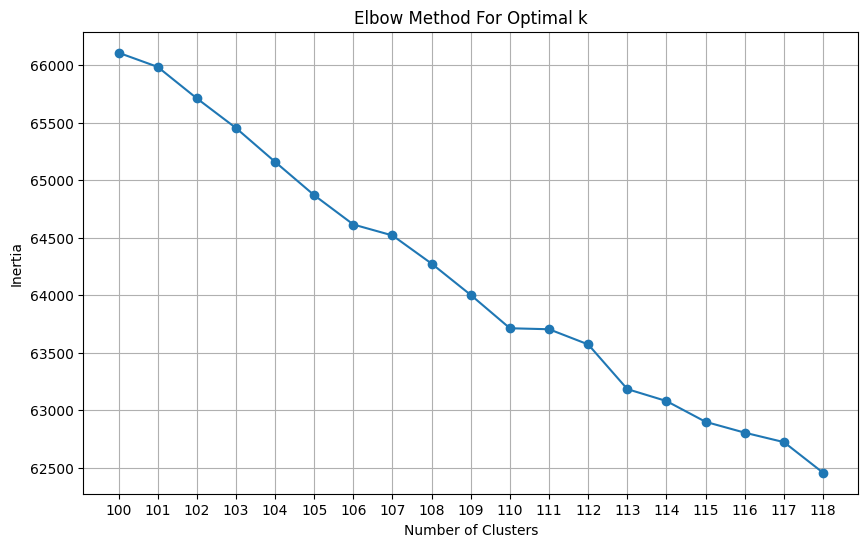

In [21]:
inertia_values = []
cluster_range = range(100, 119)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

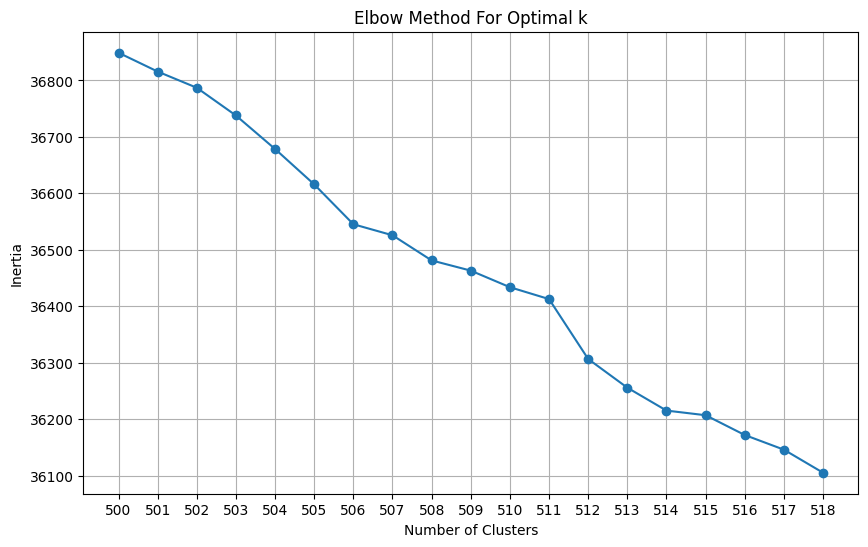

In [22]:
inertia_values = []
cluster_range = range(500, 519)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

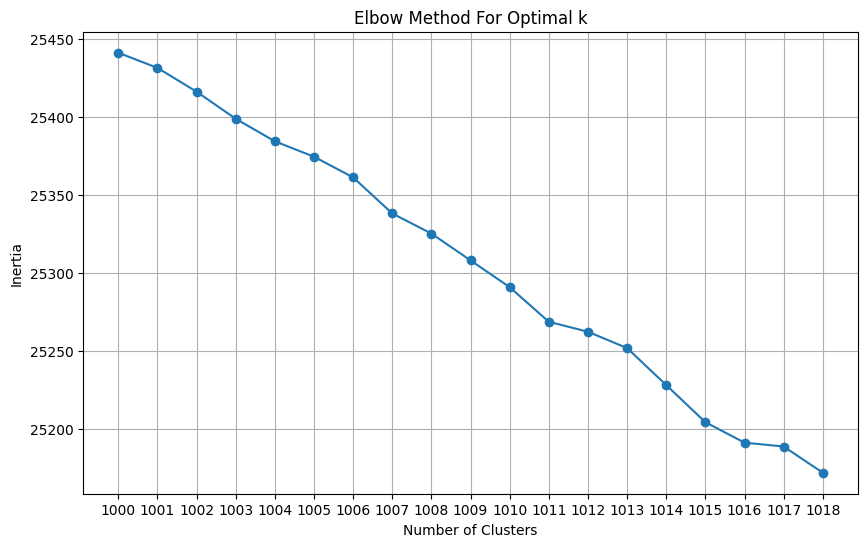

In [23]:
inertia_values = []
cluster_range = range(1000, 1019)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectorizers['noun remove-40'])
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## Analysis Each Optimum Cluster

### Cluster 100

In [24]:
optimal_k = 113
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster100'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [25]:
show_cluster('cluster100', 10)


Examples of products in Cluster 0:
                                                                           name
91                                               JERSEY BASEBALL NY HITAM POLOS
104          MEN Polo Dry Fit Kaos Olahraga Ex Lengan Pendek JASTIP UNIQLO SALE
148                     Kartu Basket James Harden (2020-21 Donruss Net Marvels)
191  SVRG. Elbow Sleeve - Deker Pelindung Tangan Siku Olahraga Basket Gym Murah
192      AirFit - Hijab Sport Jilbab Olahraga Instan Bahan Jersey Super Premium

Examples of products in Cluster 1:
                                                                       name
58           PHI249 Celana Pendek Jeans Bayi Anak Perempuan Old Navy | Baby
127              celana dalam ihram tanpa jahit ukuran JUMBO ( XXXL ) 1 pcs
195      celana kulot panjang wanita cargo bahan katun twill combed premium
299       Celana Tactical Panjang Pria Kargo Cargo Pants Model M-Tac Series
328  Baggy Pants Premium Celana Polos Panjang Wanita (Kerja Kuliah H

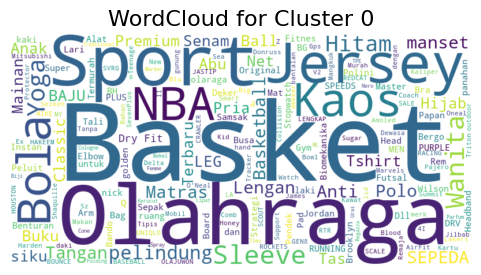

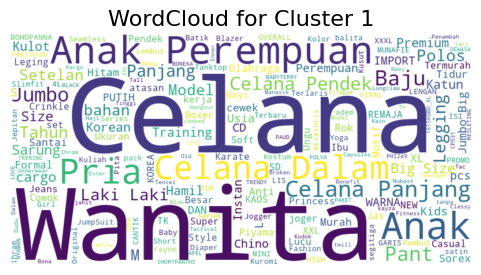

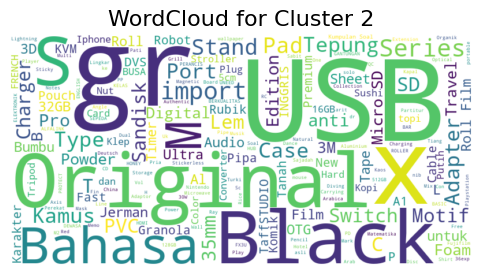

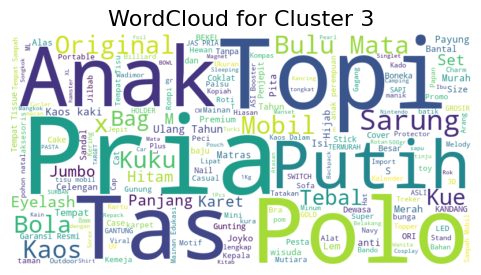

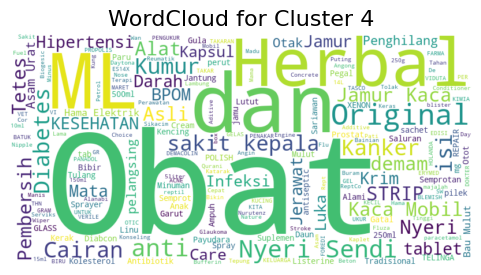

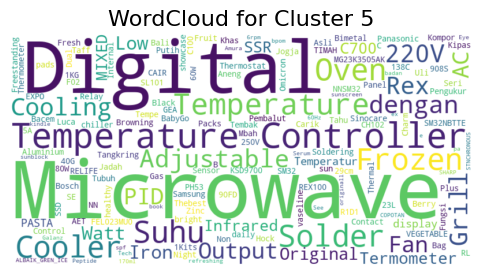

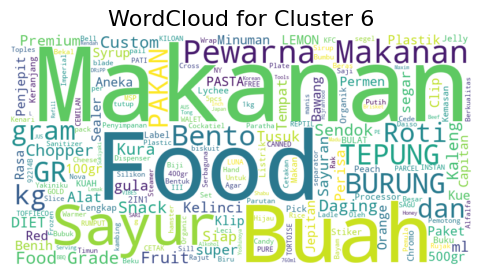

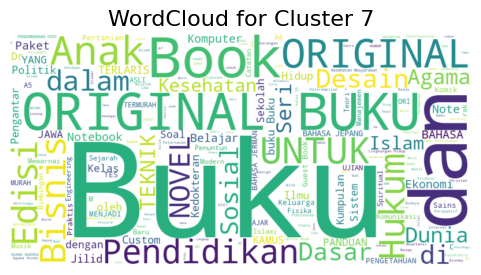

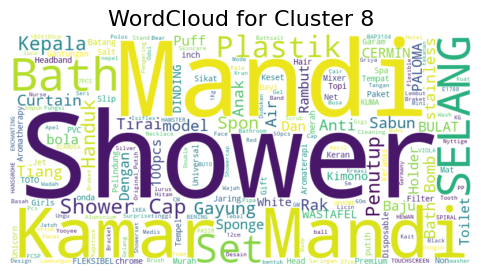

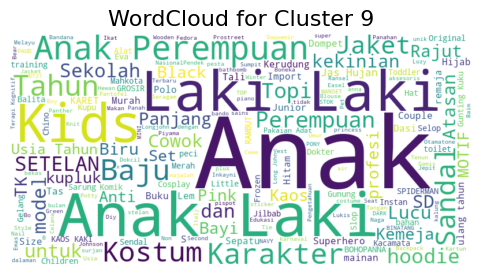

In [26]:
show_wordclouds('cluster100', 10)

### Cluster 500

In [27]:
optimal_k = 507
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster500'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [28]:
show_cluster('cluster500', 10)


Examples of products in Cluster 0:
                                                                       name
2436            CHECK VALVE RECEIVER  R150CV BRAND FAST FILL ORIGINAL + CAP
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
3324              Mama Bear Almon Mix Pelancar Asi Booster Mama Bear Almond
4884  Mom Uung Asi Booster Pelancar Asi Momuung Kapsul Kelor Pil BPOM Halal
6731    TORTEA Teh Pelancar ASI Booster Torbangun Herbal Untuk Ibu Menyusui

Examples of products in Cluster 1:
                                                                      name
4    Buku Ilmu Sosial Budaya Dasar Perspektif Baru Membangun Kesadaran ani
62        BUKU PSIKOLOGI MODERN DALAM PERSPEKTIF AGAMA BUDDHA S DHAMMASIRI
111        Buku Bimbingan dan Konseling Belajar - Deepublish Original ISBN
141       BUKU PENANGANAN LIMBAH INDUSTRI PETERNAKAN - SUHARJONO TRIATMOJO
144                      buku seri penemuan ilmiah Louis Pasteur dan kuman

Examples of products 

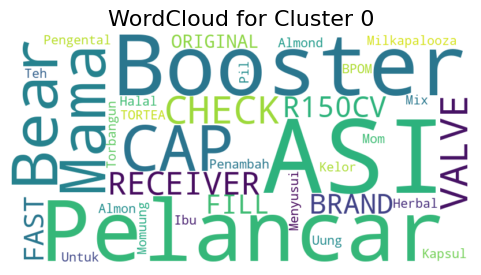

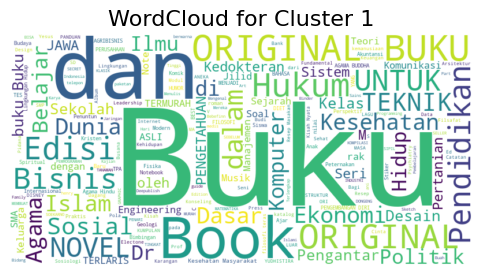

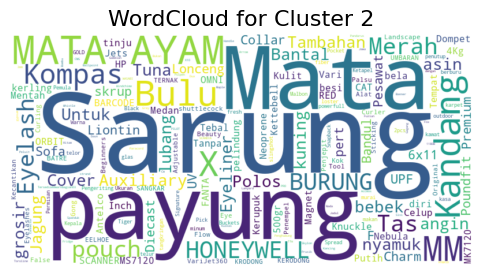

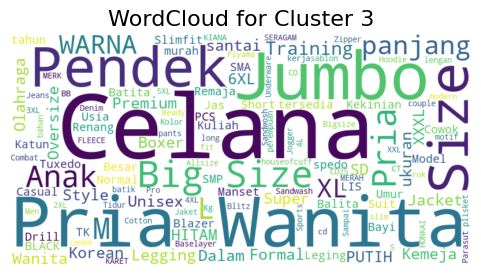

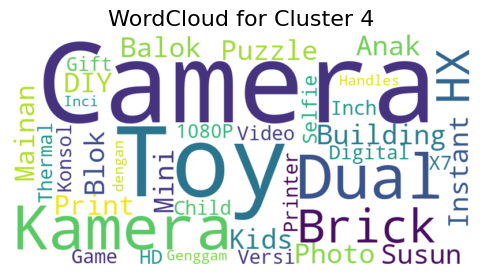

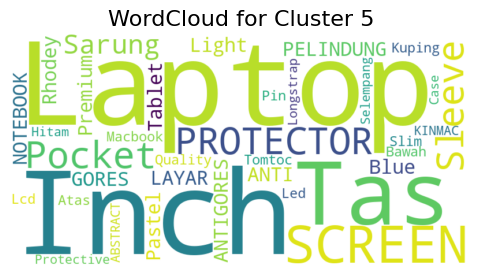

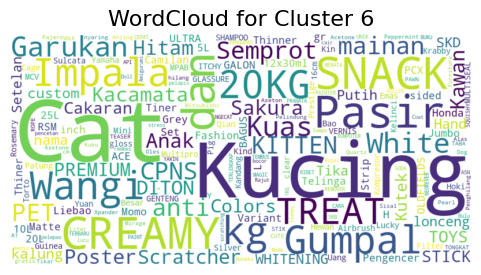

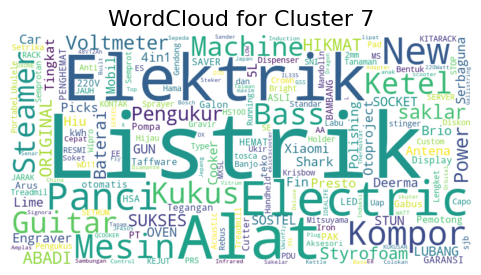

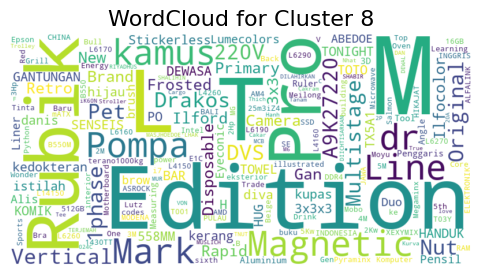

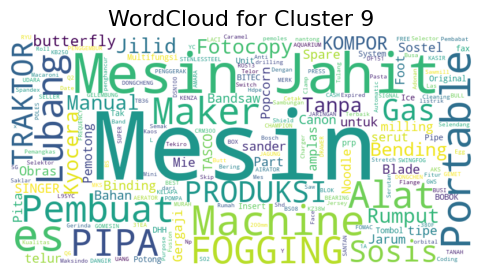

In [29]:
show_wordclouds('cluster500', 10)

### Cluster 1000

In [30]:
optimal_k = 1010
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster1000'] = kmeans.fit_predict(vectorizers['noun remove-40'])

In [31]:
show_cluster('cluster1000', 10)


Examples of products in Cluster 0:
                                                                       name
2436            CHECK VALVE RECEIVER  R150CV BRAND FAST FILL ORIGINAL + CAP
3019  Milkapalooza ASI Booster / Pelancar / Penambah / Pengental ASI 60 cap
3324              Mama Bear Almon Mix Pelancar Asi Booster Mama Bear Almond
4884  Mom Uung Asi Booster Pelancar Asi Momuung Kapsul Kelor Pil BPOM Halal
6731    TORTEA Teh Pelancar ASI Booster Torbangun Herbal Untuk Ibu Menyusui

Examples of products in Cluster 1:
                                                                      name
4    Buku Ilmu Sosial Budaya Dasar Perspektif Baru Membangun Kesadaran ani
111        Buku Bimbingan dan Konseling Belajar - Deepublish Original ISBN
141       BUKU PENANGANAN LIMBAH INDUSTRI PETERNAKAN - SUHARJONO TRIATMOJO
144                      buku seri penemuan ilmiah Louis Pasteur dan kuman
173  Buku Agama Kristen, KONSELING PASTORAL DALAM TRANSISI (Charles V. G.)

Examples of products 

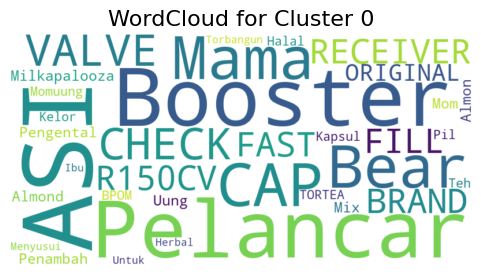

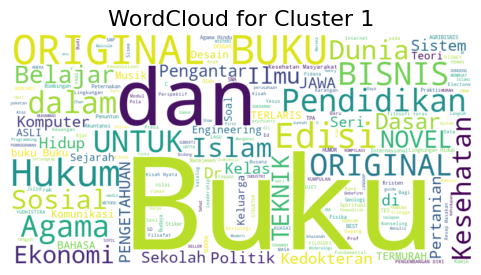

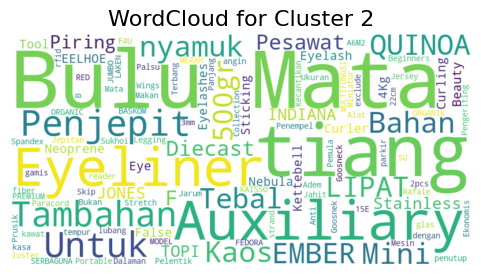

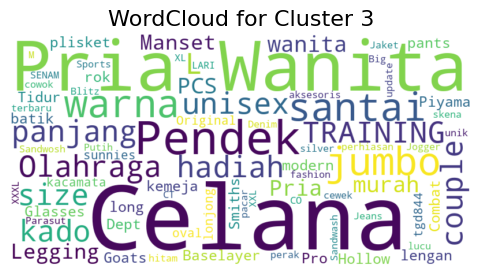

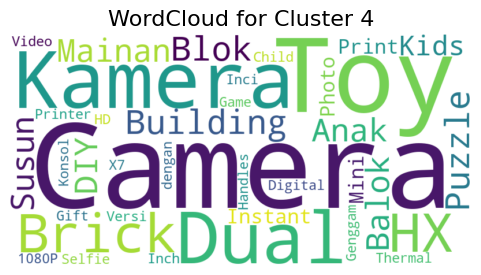

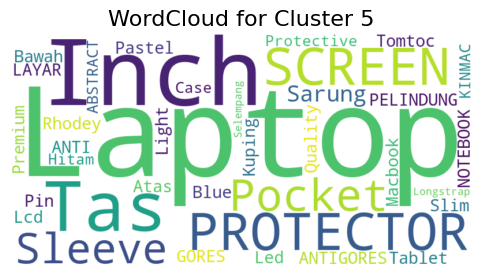

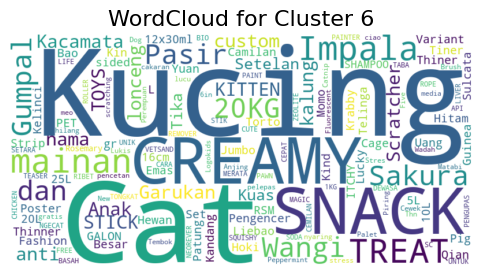

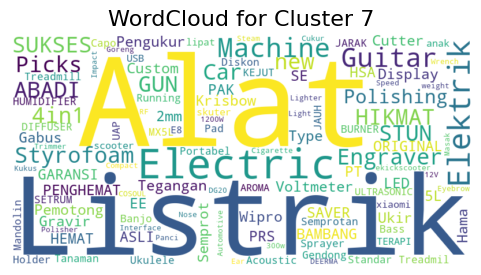

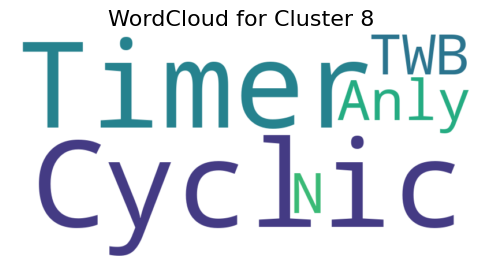

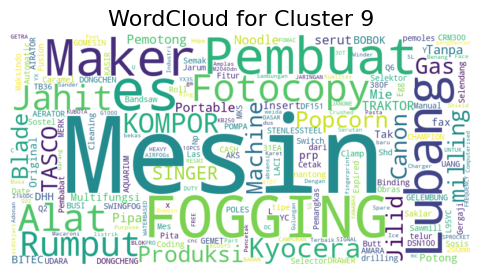

In [32]:
show_wordclouds('cluster1000', 10)